In [10]:
import os
import collections
import chainer
from chainer import Variable
from chainer import links as L
from chainer import functions as F
import numpy as np
import cupy as cp
from imagenet_class_id import CLASS_ID
import matplotlib.pyplot as plt

In [12]:
from chainer.dataset import download
from chainer.serializers import npz
import numpy as np
from PIL import Image



def convert_caffemodel_to_npz(path_caffemodel, path_npz):
    from chainer.links.caffe.caffe_function import CaffeFunction
    caffemodel = CaffeFunction(path_caffemodel)
    npz.save_npz(path_npz, caffemodel, compression=False)


def _make_npz(path_npz, url, model):
    path_caffemodel = download.cached_download(url)
    print('Now loading caffemodel (usually it may take few minutes)')
    convert_caffemodel_to_npz(path_caffemodel, path_npz)
    npz.load_npz(path_npz, model)
    return model


def _retrieve(name, url, model):
    root = download.get_dataset_directory('pfnet/chainer/models/')
    path = os.path.join(root, name)
    return download.cache_or_load_file(
        path, lambda path: _make_npz(path, url, model),
        lambda path: npz.load_npz(path, model))


def read_image(path, dtype=np.float32, color=True):
    """Read an image from a file.
    This function reads an image from given file. The image is CHW format and
    the range of its value is :math:`[0, 255]`. If :obj:`color = True`, the
    order of the channels is RGB.
    Args:
        path (string): A path of image file.
        dtype: The type of array. The default value is :obj:`~numpy.float32`.
        color (bool): This option determines the number of channels.
            If :obj:`True`, the number of channels is three. In this case,
            the order of the channels is RGB. This is the default behaviour.
            If :obj:`False`, this function returns a grayscale image.
    Returns:
        ~numpy.ndarray: An image.
    """

    f = Image.open(path)
    try:
        if color:
            img = f.convert('RGB')
        else:
            img = f.convert('P')
        img = np.asarray(img, dtype=dtype)
    finally:
        if hasattr(f, 'close'):
            f.close()

    return img

def VGGprepare(path, size=(224, 224)):
    """Converts the given image to the numpy array for VGG models.
    Note that you have to call this method before ``__call__``
    because the pre-trained vgg model requires to resize the given image,
    covert the RGB to the BGR, subtract the mean,
    and permute the dimensions before calling.
    Args:
        image (PIL.Image or numpy.ndarray): Input image.
            If an input is ``numpy.ndarray``, its shape must be
            ``(height, width)``, ``(height, width, channels)``,
            or ``(channels, height, width)``, and
            the order of the channels must be RGB.
        size (pair of ints): Size of converted images.
            If ``None``, the given image is not resized.
    Returns:
        numpy.ndarray: The converted output array.
    """

    image = read_image(path)
    if isinstance(image, np.ndarray):
        if image.ndim == 3:
            if image.shape[0] == 1:
                image = image[0, :, :]
            elif image.shape[0] == 3:
                image = image.transpose((1, 2, 0))
        image = Image.fromarray(image.astype(np.uint8))
    image = image.convert('RGB')
    if size:
        image = image.resize(size)
    image = np.asarray(image, dtype=np.float32)
    image = image[:, :, ::-1]
    image -= np.array(
        [103.939, 116.779, 123.68], dtype=np.float32)
    image = image.transpose((2, 0, 1))
    return np.expand_dims(image, 0)

def image_from_var(var, device):
    """
    """
    if device<0:
        img = np.squeeze(var.data)
    else:
        img = np.squeeze(cp.asnumpy(var.data))
    img = img.transpose((1, 2, 0))
    img += np.array([103.939, 116.779, 123.68], dtype=np.float32)
    img = img[:, :, ::-1]
    #     img = img.transpose((2, 0, 1))
    return np.clip(img / 255, 0, 1)

In [4]:
class VGG16(chainer.Chain):

    def __init__(self):
        super(VGG16, self).__init__()
        with self.init_scope():
            self.conv1_1 = L.Convolution2D(3, 64, 3, 1, 1)
            self.conv1_2 = L.Convolution2D(64, 64, 3, 1, 1)
            self.conv2_1 = L.Convolution2D(64, 128, 3, 1, 1)
            self.conv2_2 = L.Convolution2D(128, 128, 3, 1, 1)
            self.conv3_1 = L.Convolution2D(128, 256, 3, 1, 1)
            self.conv3_2 = L.Convolution2D(256, 256, 3, 1, 1)
            self.conv3_3 = L.Convolution2D(256, 256, 3, 1, 1)
            self.conv4_1 = L.Convolution2D(256, 512, 3, 1, 1)
            self.conv4_2 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv4_3 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv5_1 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv5_2 = L.Convolution2D(512, 512, 3, 1, 1)
            self.conv5_3 = L.Convolution2D(512, 512, 3, 1, 1)
            self.fc6 = L.Linear(512 * 7 * 7, 4096)
            self.fc7 = L.Linear(4096, 4096)
            self.fc8 = L.Linear(4096, 1000)

        _retrieve(
            'VGG_ILSVRC_16_layers.npz',
            'http://www.robots.ox.ac.uk/%7Evgg/software/very_deep/'
            'caffe/VGG_ILSVRC_16_layers.caffemodel',
            self)

        self.size = 224
        self.functions = collections.OrderedDict([
            ('conv1_1', [self.conv1_1, F.relu]),
            ('conv1_2', [self.conv1_2, F.relu]),
            ('pool1', [_max_pooling_2d]),
            ('conv2_1', [self.conv2_1, F.relu]),
            ('conv2_2', [self.conv2_2, F.relu]),
            ('pool2', [_max_pooling_2d]),
            ('conv3_1', [self.conv3_1, F.relu]),
            ('conv3_2', [self.conv3_2, F.relu]),
            ('conv3_3', [self.conv3_3, F.relu]),
            ('pool3', [_max_pooling_2d]),
            ('conv4_1', [self.conv4_1, F.relu]),
            ('conv4_2', [self.conv4_2, F.relu]),
            ('conv4_3', [self.conv4_3, F.relu]),
            ('pool4', [_max_pooling_2d]),
            ('conv5_1', [self.conv5_1, F.relu]),
            ('conv5_2', [self.conv5_2, F.relu]),
            ('conv5_3', [self.conv5_3, F.relu]),
            ('pool5', [_max_pooling_2d]),
            ('fc6', [self.fc6, F.relu, F.dropout]),
            ('fc7', [self.fc7, F.relu, F.dropout]),
            ('fc8', [self.fc8]),
            ('prob', [F.softmax]),
        ])
    
    def __call__(self, inp):
        h = inp
        for key, funcs in self.functions.items():
            for func in funcs:
                h = func(h)
        return h


def _max_pooling_2d(x):
    return F.max_pooling_2d(x, ksize=2)

In [5]:



vgg = VGG16()



Now loading caffemodel (usually it may take few minutes)


In [8]:

def adv_decrease(img_path, lr=1000, device=0, nb_iteration=160):
    if device>=0:
        gpu = True
    else:
        gpu = False

    if gpu:
        vgg.to_gpu()

    original_image = Variable(VGGprepare(img_path))
    var_image = original_image
    
    if gpu:
        var_image.to_gpu(0)

    pred_prob_list = []
    for i in range(nb_iteration):

        output = vgg(var_image)

    if gpu:
        output.grad = cp.zeros_like(output)
    else:
        output.grad = np.zeros_like(output).astype(np.float32)

    if i==0:
        if gpu:
        
            initial_class_pred = np.expand_dims(cp.asnumpy(F.argmax(output).data), 0)[0]
            print("Initial class predicted : ",CLASS_ID[initial_class_pred])
      
        else:

            initial_class_pred = np.expand_dims(F.argmax(output).data, 0)[0]
            print("Initial class predicted : ",CLASS_ID[initial_class_pred])

    if i % 10 == 0:
        print(i," ",output[0][initial_class_pred])

    if gpu:
        pred_prob_list.append(np.expand_dims(cp.asnumpy(output[0][initial_class_pred].data),0)[0])
    else:
        pred_prob_list.append(np.expand_dims(output[0][initial_class_pred].data,0)[0])

    output.grad[0][initial_class_pred] = 1
    output.backward(retain_grad = True)
    var_image -= lr*var_image.grad_var
    vgg.cleargrads()
    var_image.cleargrad()
        
        
    

    if gpu:
        final_class_pred = np.expand_dims(cp.asnumpy(F.argmax(output).data), 0)[0]
    else:
        final_class_pred = np.expand_dims(F.argmax(output).data, 0)[0]

    print("Final class predicted : ",CLASS_ID[final_class_pred])

    fig1 = plt.figure(figsize=(15,10))

    ax1= plt.subplot2grid((6, 9), (0, 0), colspan=3, rowspan=3)
    ax1.set_title("Initial Prediction: "+CLASS_ID[initial_class_pred].split(',')[0], color='teal')
    ax1.axis('off')
    ax1.imshow(image_from_var(original_image, device))


    ax2= plt.subplot2grid((6, 9), (0, 3), colspan=3, rowspan=3)
    ax2.set_title("+ Noise added ", color='teal')
    ax2.axis('off')
    ax2.imshow(image_from_var(var_image - original_image, device))

    ax3= plt.subplot2grid((6, 9), (0, 6), colspan=3, rowspan=3)
    ax3.set_title("Final Prediction: "+CLASS_ID[final_class_pred].split(',')[0], color='teal')
    ax3.axis('off')
    ax3.imshow(image_from_var(var_image, device))


    ax4= plt.subplot2grid((6, 9), (3, 3), colspan=3, rowspan=3)
    ax4.plot(pred_prob_list)
    ax4.set_xlabel("Decreasing probability for: "+CLASS_ID[initial_class_pred].split(',')[0], color='teal')

    plt.show()
    plt.savefig('adv_reduce.png')

Initial class predicted :  ostrich, Struthio camelus
0   variable(0.99984074)
10   variable(0.9977544)
20   variable(0.999954)
30   variable(0.9976903)
40   variable(0.9999281)
50   variable(0.99972504)
60   variable(0.9995036)
70   variable(0.99973375)
80   variable(0.99998844)
90   variable(0.9961349)
100   variable(0.9998305)
110   variable(0.9911041)
120   variable(0.9979265)
130   variable(0.9999527)
140   variable(0.9975318)
150   variable(0.96053857)
160   variable(0.99053484)
170   variable(0.9365666)
180   variable(0.9804074)
190   variable(0.13361962)
200   variable(0.01138731)
210   variable(0.06224512)
220   variable(0.02667004)
230   variable(0.0046493)
240   variable(0.00238324)
250   variable(0.01085744)
260   variable(0.00471166)
270   variable(0.00206619)
280   variable(0.00013327)
290   variable(0.00030074)
Final class predicted :  bustard


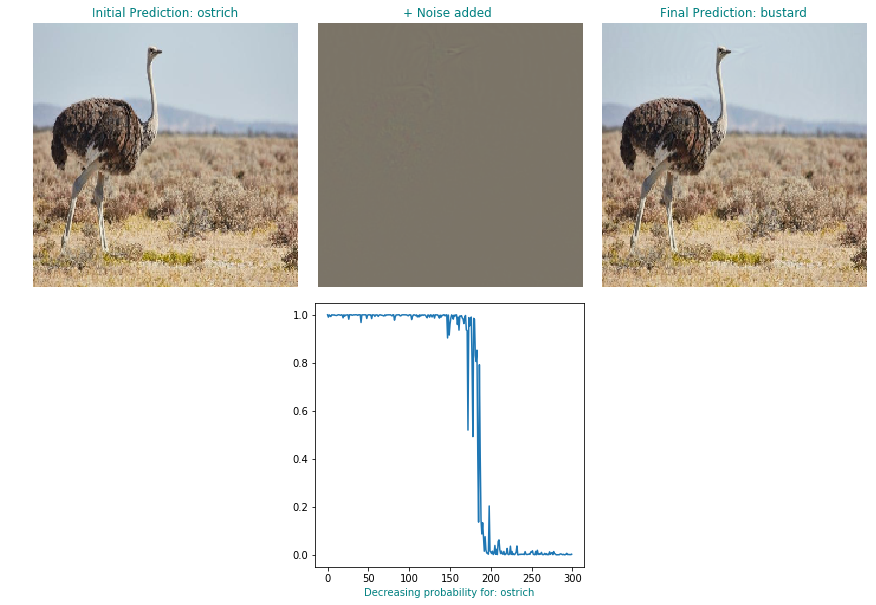

In [35]:
adv_decrease('ostrich.jpg', lr = 1e3, nb_iteration=300)


In [50]:

def adv_targeted(img_path, target_class_id, lr=1000, device=0, nb_iteration=160):
    if device>=0:
        gpu = True
    else:
        gpu = False

    if gpu:
        vgg.to_gpu()

    original_image = Variable(VGGprepare(img_path))
    var_image = original_image
    print("Target: ID-",target_class_id," - ",CLASS_ID[target_class_id])

    if gpu:
        var_image.to_gpu(0)

    pred_prob_list = []
    current_prob = 0
    i = 0
    while current_prob<.99: 

        
        output = vgg(var_image)

        if gpu:
            output.grad = cp.zeros_like(output)
        else:
            output.grad = np.zeros_like(output).astype(np.float32)

        if i==0:
            if gpu:

                initial_class_pred = np.expand_dims(cp.asnumpy(F.argmax(output).data), 0)[0]
                print("Initial class predicted : ",CLASS_ID[initial_class_pred])
      
            else:

                initial_class_pred = np.expand_dims(F.argmax(output).data, 0)[0]
                print("Initial class predicted : ",CLASS_ID[initial_class_pred])

        if i % 10 == 0:
            print(i," Target Prob",output[0][target_class_id])

        if gpu:
            pred_prob_list.append(np.expand_dims(cp.asnumpy(output[0][initial_class_pred].data),0)[0])
        else:
            pred_prob_list.append(np.expand_dims(output[0][initial_class_pred].data,0)[0])
    
        current_prob = output.data[0][target_class_id]

        pred_prob_list.append(current_prob)
        output.grad[0][target_class_id] = 1
        output.backward(retain_grad = True)
        var_image += F.clip(lr*var_image.grad_var, -16., 16.)
        vgg.cleargrads()
        var_image.cleargrad()
        i+=1


#   return original_image, var_image, pred_prob_list

# def plot_adv_decrease(original_image, var_image, pred_prob_list, device=0):
  
    fig1 = plt.figure(figsize=(15,10))

    ax1= plt.subplot2grid((6, 9), (0, 0), colspan=3, rowspan=3)
    ax1.set_title("Initial Prediction: "+CLASS_ID[initial_class_pred].split(',')[0], color='teal')
    ax1.axis('off')
    ax1.imshow(image_from_var(original_image, device))


    ax2= plt.subplot2grid((6, 9), (0, 3), colspan=3, rowspan=3)
    ax2.set_title("+ Noise added ", color='teal')
    ax2.axis('off')
    ax2.imshow(image_from_var(var_image - original_image, device))

    ax3= plt.subplot2grid((6, 9), (0, 6), colspan=3, rowspan=3)
    ax3.set_title("Final Prediction: "+CLASS_ID[target_class_id].split(',')[0], color='teal')
    ax3.axis('off')
    ax3.imshow(image_from_var(var_image, device))


    ax4= plt.subplot2grid((6, 9), (3, 3), colspan=3, rowspan=3)
    # ax4.set_subtitle("Title4")
    ax4.plot(pred_prob_list, color='r')
    ax4.set_xlabel("Probability for: "+CLASS_ID[target_class_id].split(',')[0], color='teal')

    plt.show()
    plt.savefig('adv_target.png')

Target: ID- 950  -  orange
Initial class predicted :  airship, dirigible
0  Target Prob variable(0.00021168)
10  Target Prob variable(0.00038795)
20  Target Prob variable(0.00094465)
30  Target Prob variable(0.00059938)
40  Target Prob variable(0.00034127)
50  Target Prob variable(0.00087937)
60  Target Prob variable(0.00062413)
70  Target Prob variable(0.00184894)
80  Target Prob variable(0.00421243)
90  Target Prob variable(0.03038328)
100  Target Prob variable(0.4796706)


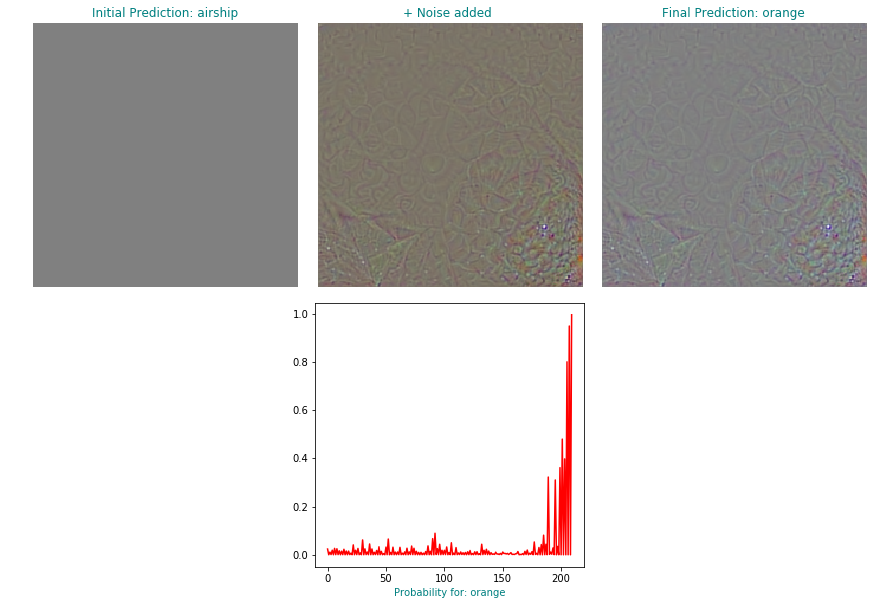

In [56]:
target_class_id = np.random.randint(1000)
adv_targeted('gray.jpg', target_class_id, lr=1e5, device=0)